# AI Project: Neural Network

#### Supervisors: Prof. Stéphane Marchand-Maillet, Assist. Vincent Micheli, Assist. Margarita Liarou

#### Students: CHRISTOFOROU Anthony Phillipous, VANSON Nathan Soufianus, WILLIAM Christian Athenaous, RASHIDI Massi Mohammedeous
---

In [82]:
# Libraries
import matplotlib
import numpy as np
from itertools import product
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Modules
from ai_nn_project.utils.tuning import parallel_grid_search_knn, parallel_grid_search_mlp
from ai_nn_project.models.neigbours.knn import KNN
from ai_nn_project.utils.visualisation import visualize_weights, plot_metrics_by_complexity, plot_metrics_by_dataset_size, plot_metrics_by_noise, plot_accuracy_during_training
from ai_nn_project.utils.activations import Sigmoid, ReLU, Linear
from ai_nn_project.models.neuronal_network.multilayer_perceptron import MLP
from ai_nn_project.utils.evaluations import accuracy, precision, recall, f1_score, mse_loss, mae_loss, rmse_loss, mape_loss, r2_score

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Introduction

## Data Preprocessing

### Mushroom Dataset: Classification

In [2]:
# fetch dataset

# Mushroom. (1987). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T.
mushroom = fetch_ucirepo(id=73) 

In [3]:
# pandas dataframe
mushroom_X = mushroom.data.features
mushroom_y = mushroom.data.targets

In [4]:
mushroom_X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [5]:
mushroom_y.head()

,poisonous
0,p
1,e
2,e
3,p
4,e


In [6]:
# Encode categorical features as a one-hot numeric array: Gives a unique number to each category
fe = OneHotEncoder()
le = LabelEncoder() # Gives a unique number to each category

mushroom_X_encoded = fe.fit_transform(mushroom_X).toarray()
mushroom_y_encoded = mushroom_y.apply(le.fit_transform).to_numpy()

# Split the dataset into train and test set
mushroom_X_train, mushroom_X_temp, mushroom_y_train, mushroom_y_temp = train_test_split(mushroom_X_encoded, mushroom_y_encoded, test_size=0.4, random_state=42)
# Split the test set into validation and test set
mushroom_X_val, mushroom_X_test, mushroom_y_val, mushroom_y_test = train_test_split(mushroom_X_temp, mushroom_y_temp, test_size=0.5, random_state=42)

### Wine Dataset: Regression

In [7]:
# Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.
wine_quality = fetch_ucirepo(id=186)

In [8]:
wine_X = wine_quality.data.features
wine_y = wine_quality.data.targets

In [9]:
wine_X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [10]:
wine_y.head()

,quality
0,5
1,5
2,5
3,6
4,5


In [11]:
scaler = StandardScaler()
wine_X_scaled = scaler.fit_transform(wine_X)
wine_y_scaled = wine_y.to_numpy()

# First split: Separate out a training set and a temporary set
wine_X_train, wine_X_temp, wine_y_train, wine_y_temp = train_test_split(wine_X_scaled, wine_y_scaled, test_size=0.4, random_state=42)

# Second split: Divide the temporary set into validation and test sets
wine_X_val, wine_X_test, wine_y_val, wine_y_test = train_test_split(wine_X_temp, wine_y_temp, test_size=0.5, random_state=42)

## Hyperparameter Tuning

### Classification

### K-Nearest Neighbors

In [12]:
param_grid = {
    'k': [3, 5, 15, 50, 100, 200],
}

fixed_params = {
    'mode': 'classification'
}

knn_best_param, knn_best_score, knn_results = parallel_grid_search_knn(accuracy, mushroom_X_train.copy(), mushroom_y_train.copy(), mushroom_X_val.copy(), mushroom_y_val.copy(), param_grid, fixed_params)

KNN Grid Search:   0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
print("Best parameter: ", knn_best_param)
print("Best score: ", knn_best_score)

Best parameter:  {'k': 3}
Best score:  1.0


### Multi-Layer Perceptron

In [14]:
layer_sizes_options = [32, 64, 128]
max_layers = 3  #exploring up to 3 hidden layers

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  # List of learning rates to try
    'batch_size': [12, 32, 64],  # List of batch sizes to try
    'epochs': [32, 64, 128],  # List of epochs to try
    'layer_sizes': [[mushroom_X_train.shape[1]] + list(combo) + [1] for num_layers in range(2, max_layers + 1) for combo in product(layer_sizes_options, repeat=num_layers)]
}

fixed_params = {
    'final_activation': Sigmoid(),
}

best_param, best_score, results = parallel_grid_search_mlp(mushroom_X_train.copy(), mushroom_y_train.copy(), mushroom_X_val.copy(), mushroom_y_val.copy(), param_grid, fixed_params)

MLP Grid Search:   0%|          | 0/972 [00:00<?, ?it/s]

In [15]:
print("Best parameter: ", best_param)
print("Best score: ", best_score)

Best parameter:  {'learning_rate': 0.01, 'batch_size': 12, 'epochs': 128, 'layer_sizes': [117, 32, 64, 128, 1], 'activation_objects': [<ai_nn_project.utils.activations.ReLU object at 0x7f07450e9400>, <ai_nn_project.utils.activations.ReLU object at 0x7f0744c209e0>, <ai_nn_project.utils.activations.ReLU object at 0x7f0744b24b30>, <ai_nn_project.utils.activations.Sigmoid object at 0x7f0745124b60>]}
Best score:  1.4665735187866342


### Regression

### K-Nearest Neighbors

In [16]:
param_grid = {
    'k': [3, 5, 10, 50, 100, 200],
}

fixed_params = {
    'mode': 'regression'
}

knn_best_param_reg, knn_best_score_reg, knn_results_reg = parallel_grid_search_knn(accuracy, wine_X_train.copy(), wine_y_train.copy(), wine_X_val.copy(), wine_y_val.copy(), param_grid, fixed_params)

KNN Grid Search:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
print("Best parameter: ", knn_best_param_reg)
print("Best score: ", knn_best_score_reg)

Best parameter:  {'k': 3}
Best score:  0.26712856043110084


### Multi-Layer Perceptron

In [18]:
layer_sizes_options = [32, 64, 128]
max_layers = 3  #exploring up to 3 hidden layers

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  # List of learning rates to try
    'batch_size': [12, 32, 64],  # List of batch sizes to try
    'epochs': [32, 64, 128],  # List of epochs to try
    'layer_sizes': [[wine_X_train.shape[1]] + list(combo) + [1] for num_layers in range(2, max_layers + 1) for combo in product(layer_sizes_options, repeat=num_layers)]
}

fixed_params = {
    'final_activation': Linear(),
}

best_param_reg, best_score_reg, results_reg = parallel_grid_search_mlp(wine_X_train.copy(), wine_y_train.copy(), wine_X_val.copy(), wine_y_val.copy(), param_grid, fixed_params)

MLP Grid Search:   0%|          | 0/972 [00:00<?, ?it/s]

In [19]:
print("Best parameter: ", best_param_reg)
print("Best score: ", best_score_reg)

Best parameter:  {'learning_rate': 0.1, 'batch_size': 12, 'epochs': 32, 'layer_sizes': [11, 128, 64, 64, 1], 'activation_objects': [<ai_nn_project.utils.activations.ReLU object at 0x7f073de86870>, <ai_nn_project.utils.activations.ReLU object at 0x7f0744997830>, <ai_nn_project.utils.activations.ReLU object at 0x7f0744995ca0>, <ai_nn_project.utils.activations.Linear object at 0x7f073dc241d0>]}
Best score:  0.567359507313318


## Baseline K-Nearest Neighbors: Classification

In [20]:
knn = KNN(**knn_best_param)
knn.fit(mushroom_X_train, mushroom_y_train)
mushroom_output = knn.predict(mushroom_X_test)

In [21]:
mushroom_output = mushroom_output.reshape(-1, 1)

print("Accuracy: ", accuracy(mushroom_y_test, mushroom_output))
print("Precision: ", precision(mushroom_y_test, mushroom_output))
print("Recall: ", recall(mushroom_y_test, mushroom_output))
print("F1-Score: ", f1_score(mushroom_y_test, mushroom_output))

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-Score:  1.0


## Multi-Layer Perceptron: Classification

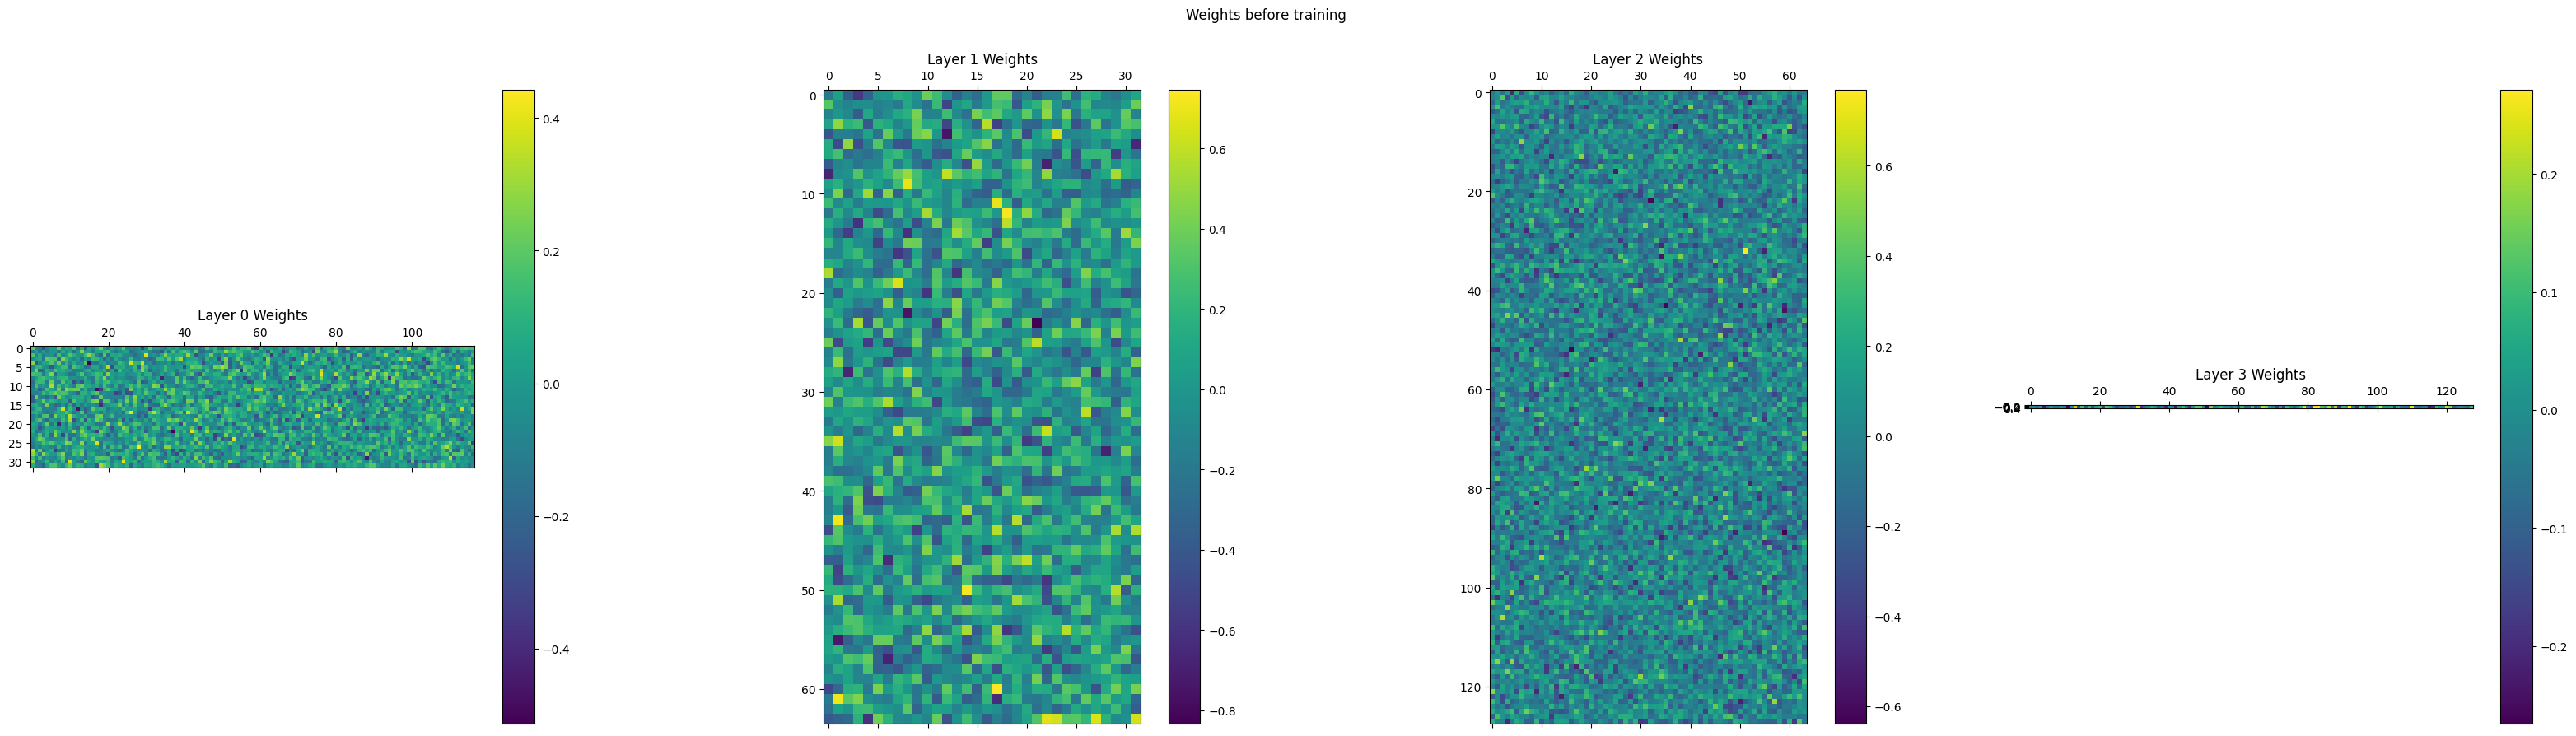

Training Progress:   0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1/128 - {'cross_entropy_loss': 19.50158240434842, 'accuracy': 0.4353713582273287, 'precision': 2.0, 'recall': 2122.0, 'f1_score': 3.9962335216572504}
Epoch 2/128 - {'cross_entropy_loss': 17.269568410376365, 'accuracy': 0.5, 'precision': 1.0, 'recall': 2197.0, 'f1_score': 1.9990900818926296}
Epoch 3/128 - {'cross_entropy_loss': 17.836294662698027, 'accuracy': 0.4835863766926549, 'precision': 2.0, 'recall': 2357.0, 'f1_score': 3.996608732513777}
Epoch 4/128 - {'cross_entropy_loss': 17.52449610681455, 'accuracy': 0.4926138695116947, 'precision': 2.0, 'recall': 2401.0, 'f1_score': 3.9966708281315024}
Epoch 5/128 - {'cross_entropy_loss': 17.092625624441155, 'accuracy': 0.5051292572835453, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
Epoch 6/128 - {'cross_entropy_loss': 17.269587686678793, 'accuracy': 0.5, 'precision': 1.0, 'recall': 2432.0, 'f1_score': 1.9991779695848746}
Epoch 7/128 - {'cross_entropy_loss': 16.68869541689839, 'accuracy': 0.5168239638900287, 'precision': 0.0, 're

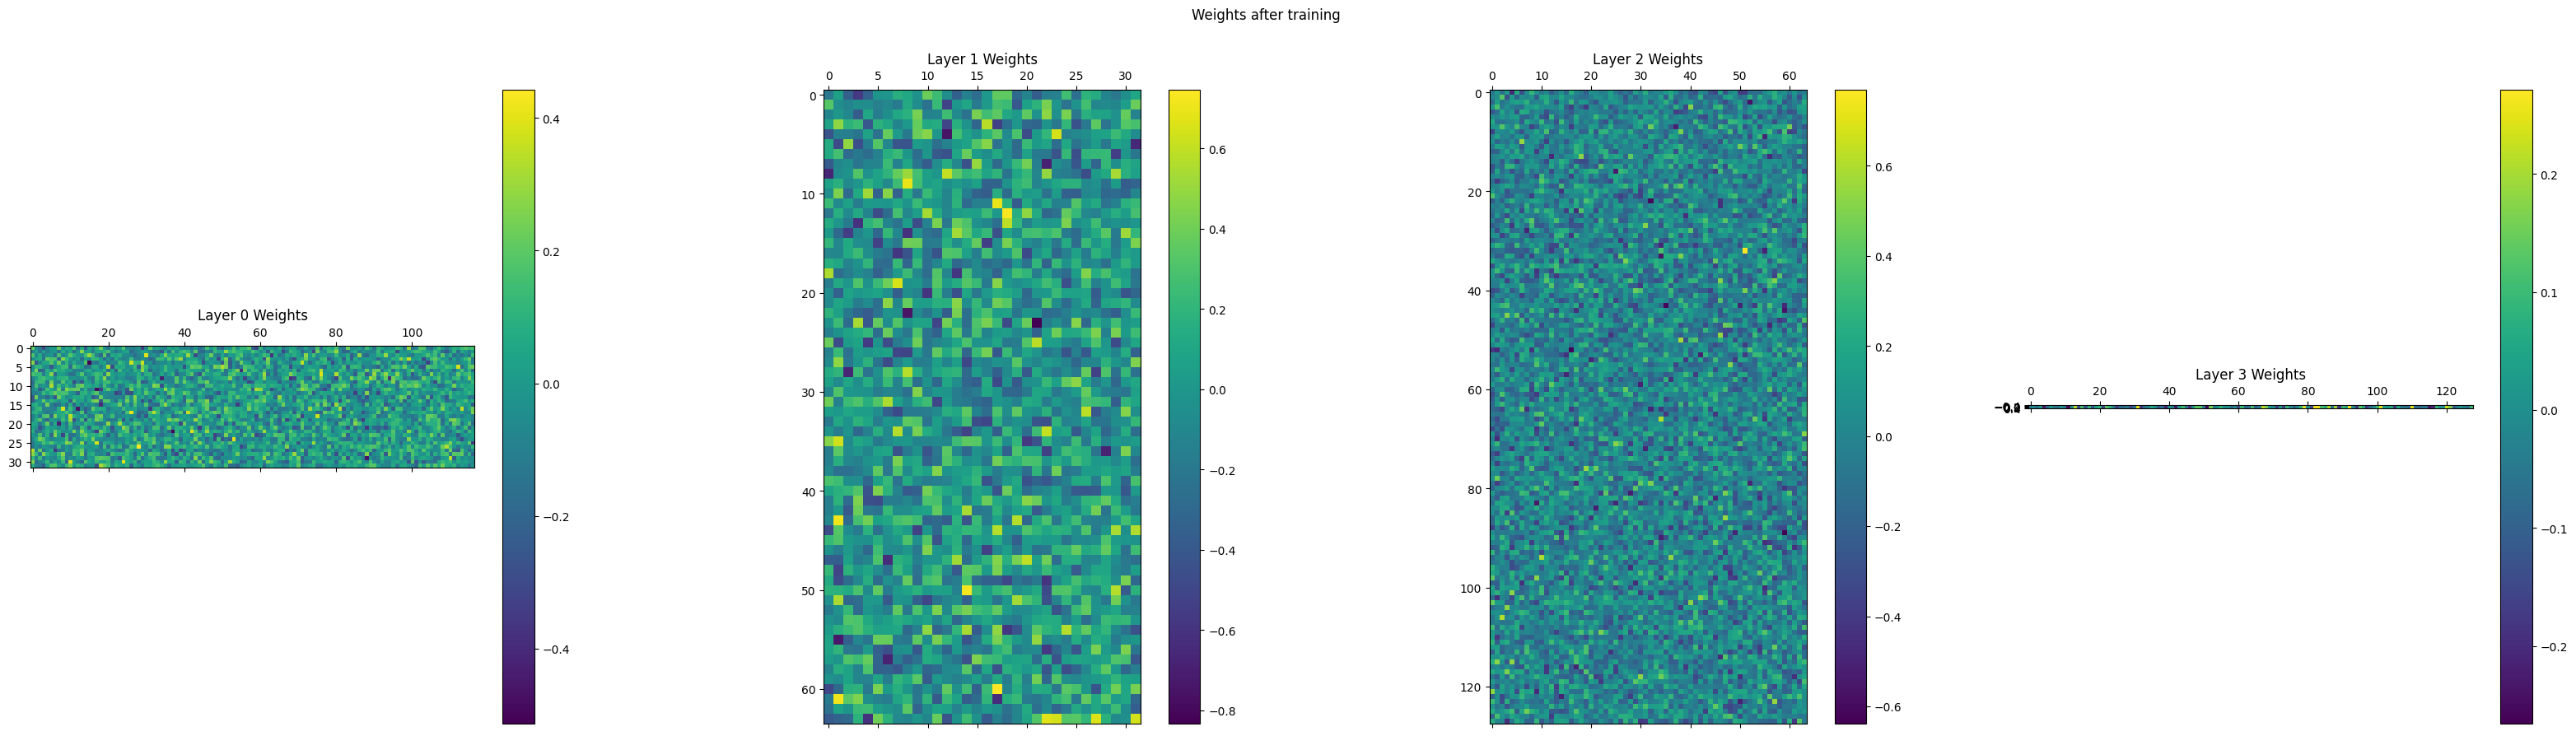

In [22]:
mushroom_network = MLP(**best_param)

visualize_weights(mushroom_network, title="Weights before training")

metrics = mushroom_network.fit(mushroom_X_train, mushroom_y_train, verbose=True)

visualize_weights(mushroom_network, title="Weights after training")

In [23]:
mushroom_output = mushroom_network.predict(mushroom_X_test.T)

# convert to binary
mushroom_output = np.where(mushroom_output >= 0.5, 1, 0)

print("Accuracy: ", accuracy(mushroom_y_test, mushroom_output.T))
print("Precision: ", precision(mushroom_y_test, mushroom_output.T))
print("Recall: ", recall(mushroom_y_test, mushroom_output.T))
print("F1-Score: ", f1_score(mushroom_y_test, mushroom_output.T))

Accuracy:  0.8289230769230769
Precision:  0.8282950423216445
Recall:  0.8343483556638246
F1-Score:  0.8313106796116505


## Baseline K-Nearest Neighbors: Regression

In [24]:
knn = KNN(**knn_best_param_reg)
knn.fit(wine_X_train, wine_y_train)
wine_output = knn.predict(wine_X_test) 

In [25]:
wine_output = np.round(wine_output).reshape(-1, 1)

print("Accuracy: ", accuracy(wine_y_test, wine_output))
print("MSE: ", mse_loss(wine_y_test, wine_output))

Accuracy:  0.5461538461538461
MSE:  0.7769230769230769


## Multi-Layer Perceptron: Reggression

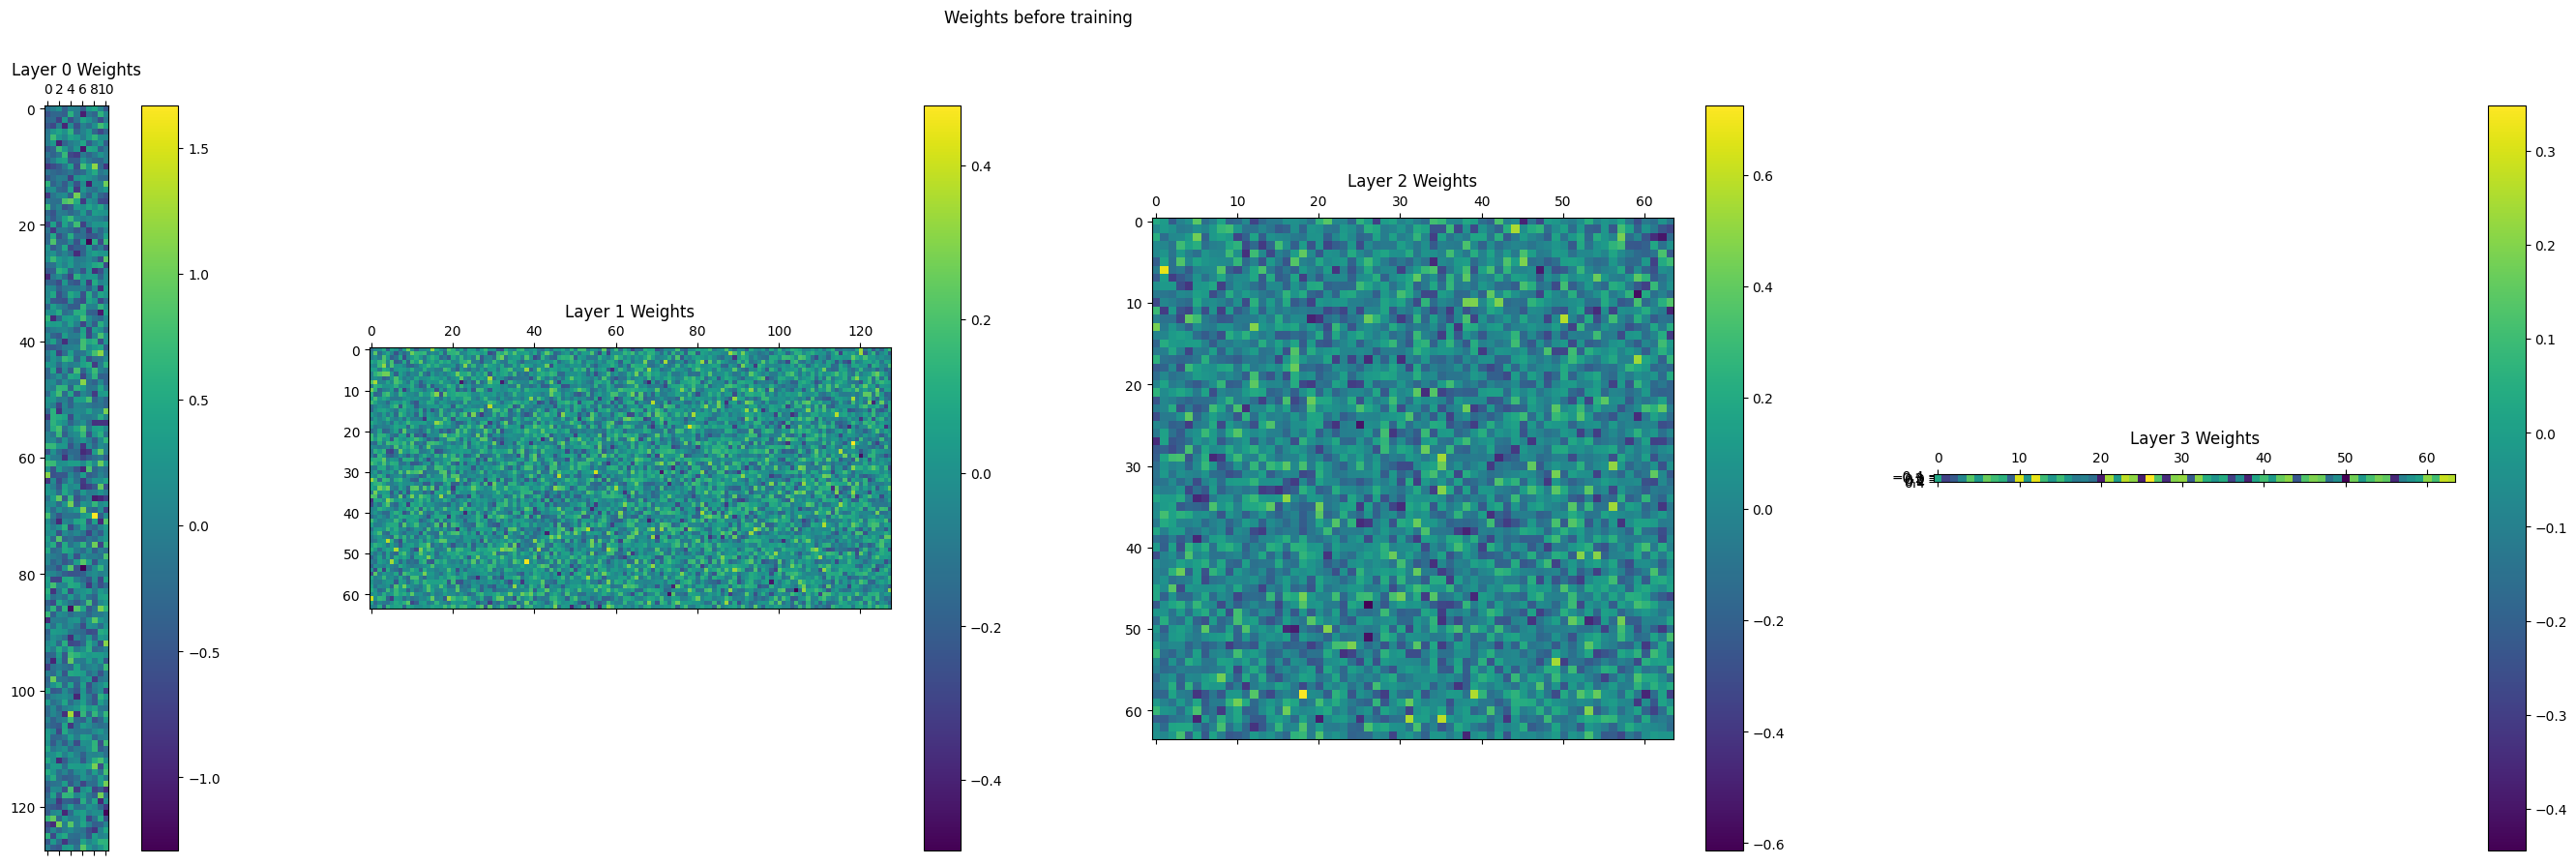

Training Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/32 - {'accuracy': 0.4171113391482812, 'mse_loss': 0.9298614674191893, 'mae_loss': 0.6811698306824012, 'mape_loss': 0.11071453003798754, 'r2_score': -7396.142857142857}
Epoch 2/32 - {'accuracy': 0.4524884556182658, 'mse_loss': 0.7531554643406876, 'mae_loss': 0.6051821446895844, 'mape_loss': 0.10827530601576815, 'r2_score': -7159.487804878049}
Epoch 3/32 - {'accuracy': 0.2850436121087737, 'mse_loss': 1.0981528989225244, 'mae_loss': 0.8340174448435095, 'mape_loss': 0.14316377140650527, 'r2_score': -5631.368421052632}
Epoch 4/32 - {'accuracy': 0.2936377629553617, 'mse_loss': 1.4518727552591073, 'mae_loss': 0.9406362237044639, 'mape_loss': 0.18713406141953515, 'r2_score': -5388.9047619047615}
Epoch 5/32 - {'accuracy': 0.42396100564392, 'mse_loss': 0.8347357619291944, 'mae_loss': 0.6579271421241663, 'mape_loss': 0.11363959539490327, 'r2_score': -6639.408163265306}
Epoch 6/32 - {'accuracy': 0.3551564905079528, 'mse_loss': 1.8939969214982042, 'mae_loss': 0.9543355566957414, 'mape_loss'

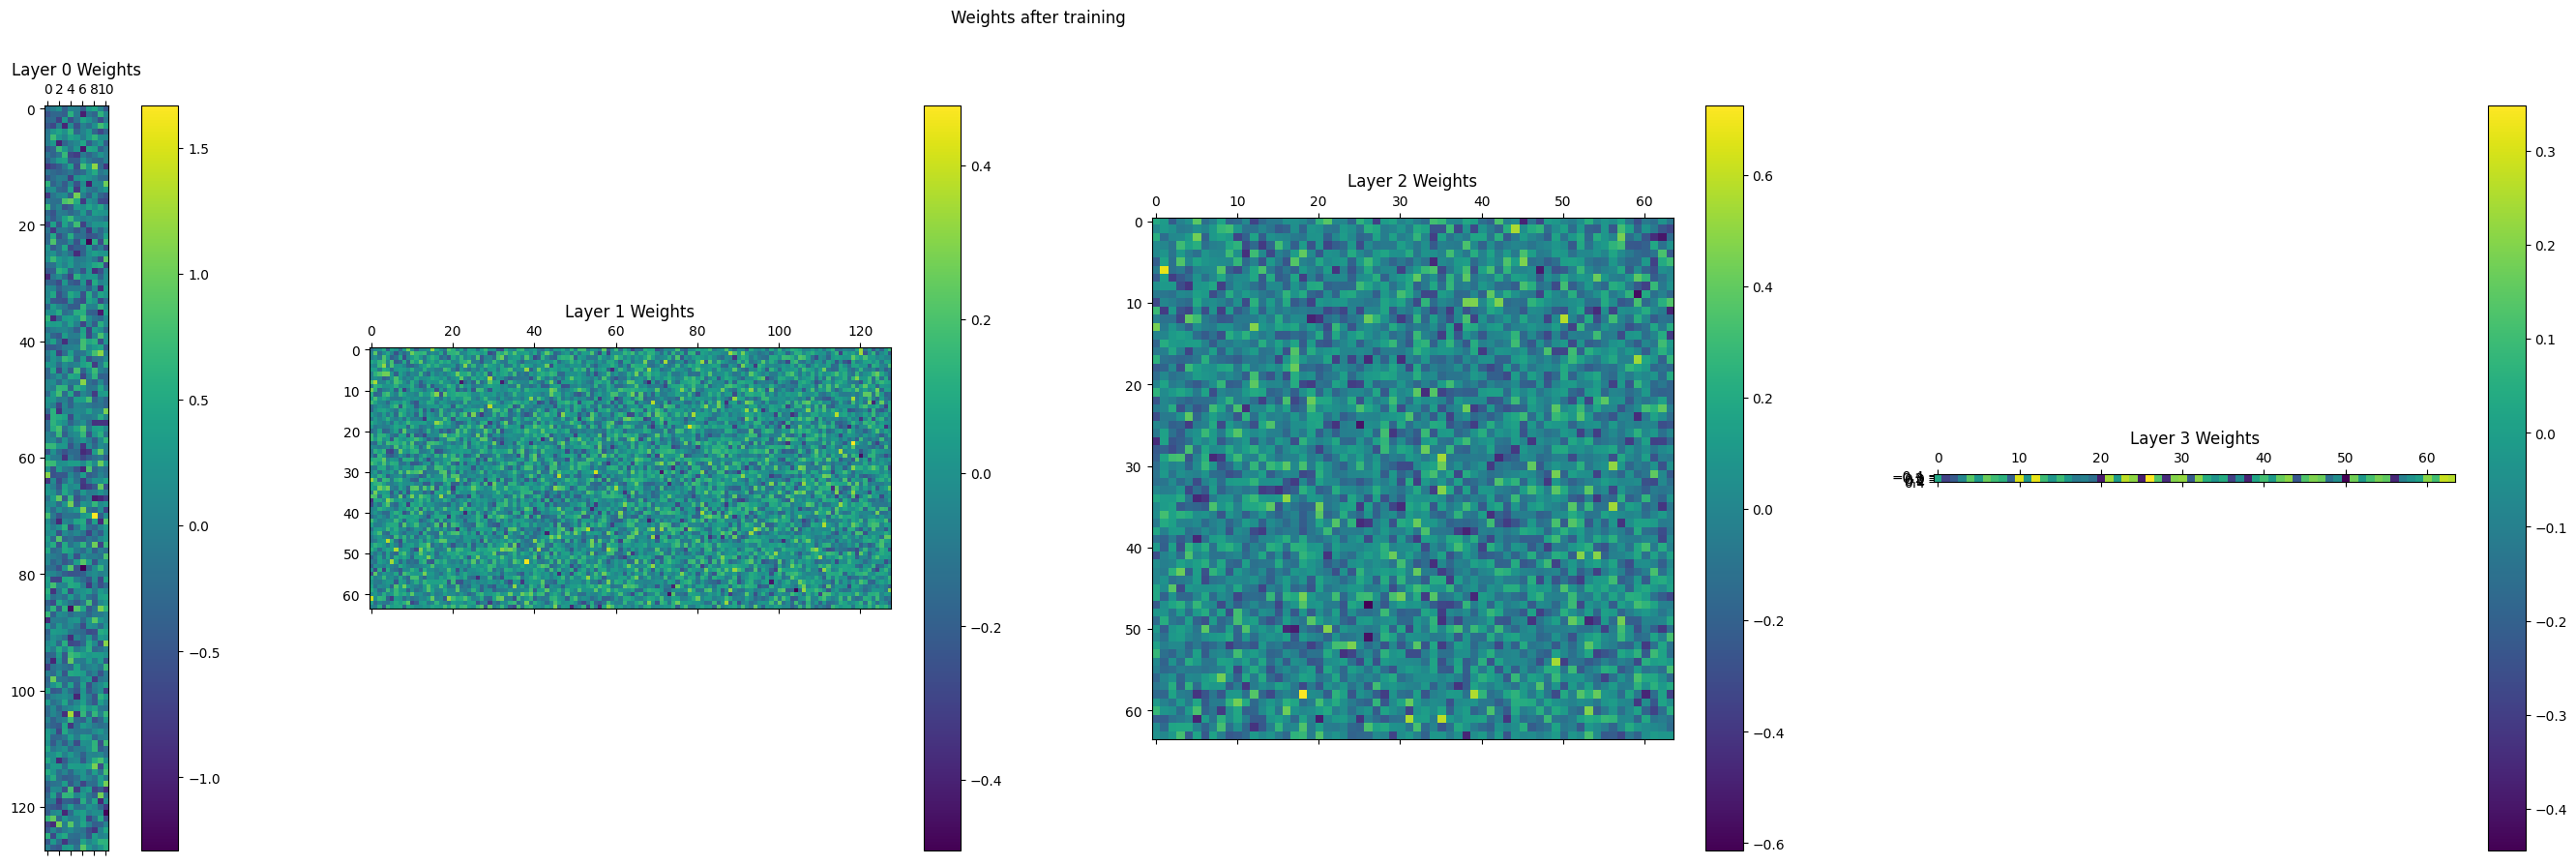

In [26]:
wine_network = MLP(**best_param_reg)

visualize_weights(wine_network, title="Weights before training")

metrics = wine_network.fit(wine_X_train, wine_y_train, verbose=True)

visualize_weights(wine_network, title="Weights after training")

In [27]:
wine_output = wine_network.predict(wine_X_test.T) 
wine_output = np.round(wine_output)

print("Accuracy: ", accuracy(wine_y_test, wine_output.T))
print("MSE: ", mse_loss(wine_y_test, wine_output.T))
print("MAE: ", mae_loss(wine_y_test, wine_output.T))
print("RMSE: ", rmse_loss(wine_y_test, wine_output.T))
print("MAPE: ", mape_loss(wine_y_test, wine_output.T))
print("R2: ", r2_score(wine_y_test, wine_output.T))

Accuracy:  0.5184615384615384
MSE:  0.7792307692307693
MAE:  0.55
RMSE:  0.8827404880432127
MAPE:  0.09768864468679714
R2:  -0.009378659946162271


## Analysis

### Overfitting: Noise and Size Variation

#### Classification

Training Noise

In [62]:
# add ndifferent level of noise to the dataset and see how the model performs
noises = [0.01, 0.05, 0.1, 0.2, 0.5]
training_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
for noise in tqdm(noises, desc=f"Noise level"):
    print("|Noise: ", noise, "|")
    
    # add some noise to the dataset
    mushroom_X_train_noisy = mushroom_X_train.copy() + np.random.normal(0, noise, mushroom_X_train.shape)
    mushroom_y_train_noisy = mushroom_y_train.copy() + np.random.normal(0, noise, mushroom_y_train.shape)
    
    mushroom_X_train_noisy = np.where(mushroom_X_train_noisy >= 0.5, 1, 0)
    mushroom_y_train_noisy = np.where(mushroom_y_train_noisy >= 0.5, 1, 0)

    # train the model
    mlp_noisy = MLP(**best_param)
    metrics = mlp_noisy.fit(mushroom_X_train_noisy, mushroom_y_train_noisy, verbose=False)
    
    # evaluate the model
    mushroom_output = mlp_noisy.predict(mushroom_X_test.T)
    mushroom_output = np.where(mushroom_output >= 0.5, 1, 0)
    
    training_scores["accuracy"].append(accuracy(mushroom_y_test, mushroom_output.T))
    training_scores["precision"].append(precision(mushroom_y_test, mushroom_output.T))
    training_scores["recall"].append(recall(mushroom_y_test, mushroom_output.T))
    training_scores["f1_score"].append(f1_score(mushroom_y_test, mushroom_output.T))

Noise level:   0%|          | 0/5 [00:00<?, ?it/s]

|Noise:  0.01 |
|Noise:  0.05 |
|Noise:  0.1 |
|Noise:  0.2 |
|Noise:  0.5 |


[0.8947692307692308, 0.8769230769230769, 0.8830769230769231, 0.8775384615384615, 0.808]
[0.9642857142857143, 0.9342657342657342, 0.9339752407152683, 0.9271978021978022, 0.8177278401997503]
[0.8221680876979294, 0.8136419001218027, 0.8270401948842875, 0.8221680876979294, 0.7978075517661388]
[0.8875739644970414, 0.8697916666666667, 0.8772609819121447, 0.8715300193673339, 0.8076448828606659]


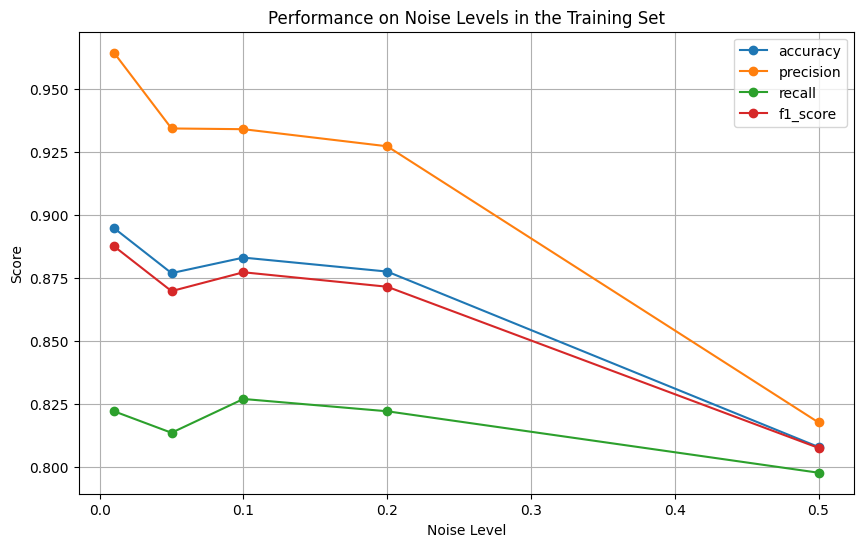

In [63]:
plot_metrics_by_noise(noises, training_scores, title="Performance on Noise Levels in the Training Set")

Testing Noise

In [64]:
# same but for noise in the labels
noises = [0.01, 0.05, 0.1, 0.2, 0.5]
test_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

for noise in noises:
    print("|Noise: ", noise, "|")
    
    # add some noise to the dataset
    mushroom_X_test_noisy = mushroom_X_test.copy() + np.random.normal(0, noise, mushroom_X_test.shape)
    mushroom_y_test_noisy = mushroom_y_test.copy() + np.random.normal(0, noise, mushroom_y_test.shape)
    
    mushroom_X_test_noisy = np.where(mushroom_X_test_noisy >= 0.5, 1, 0)
    mushroom_y_test_noisy = np.where(mushroom_y_test_noisy >= 0.5, 1, 0)
    
    # evaluate the model
    mushroom_output = mushroom_network.predict(mushroom_X_test_noisy.T)
    mushroom_output = np.where(mushroom_output >= 0.5, 1, 0)
    
    test_scores["accuracy"].append(accuracy(mushroom_y_test_noisy, mushroom_output.T))
    test_scores["precision"].append(precision(mushroom_y_test_noisy, mushroom_output.T))
    test_scores["recall"].append(recall(mushroom_y_test_noisy, mushroom_output.T))
    test_scores["f1_score"].append(f1_score(mushroom_y_test_noisy, mushroom_output.T))

|Noise:  0.01 |
|Noise:  0.05 |
|Noise:  0.1 |
|Noise:  0.2 |
|Noise:  0.5 |


[0.8289230769230769, 0.8289230769230769, 0.8289230769230769, 0.8172307692307692, 0.6283076923076923]
[0.8282950423216445, 0.8282950423216445, 0.8282950423216445, 0.8178528347406514, 0.6451612903225806]
[0.8343483556638246, 0.8343483556638246, 0.8343483556638246, 0.8228155339805825, 0.5853658536585366]
[0.8313106796116505, 0.8313106796116505, 0.8313106796116505, 0.8203266787658803, 0.6138107416879796]


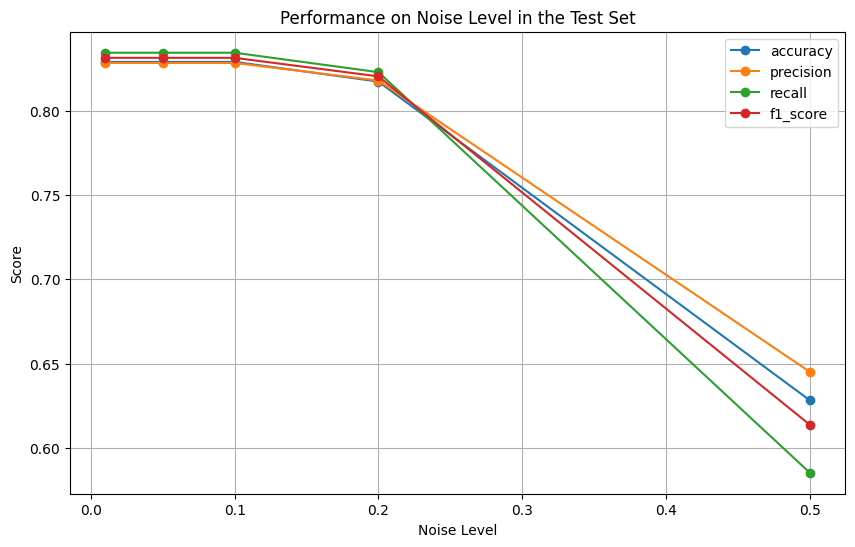

In [65]:
plot_metrics_by_noise(noises, test_scores, title='Performance on Noise Level in the Test Set')

Dataset Size

In [66]:
# variation of the size of the training set and see how the model performs
# set different sizes of the training set
sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
size_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

for size in sizes:
    print("Size: ", size)
    
    # split the training set into a small training set and a validation set
    mushroom_X_train_small, _, mushroom_y_train_small, _ = train_test_split(mushroom_X_train, mushroom_y_train, test_size=size, random_state=42)
    
    # train the model
    mlp = MLP(**best_param)
    metrics = mlp.fit(mushroom_X_train_small, mushroom_y_train_small)
    
    # evaluate the model
    mushroom_output = mlp.predict(mushroom_X_test.T)
    mushroom_output = np.where(mushroom_output >= 0.5, 1, 0)
    
    size_scores["accuracy"].append(accuracy(mushroom_y_test, mushroom_output.T))
    size_scores["precision"].append(precision(mushroom_y_test, mushroom_output.T))
    size_scores["recall"].append(recall(mushroom_y_test, mushroom_output.T))
    size_scores["f1_score"].append(f1_score(mushroom_y_test, mushroom_output.T))

Size:  0.1
Size:  0.2
Size:  0.3
Size:  0.4
Size:  0.5


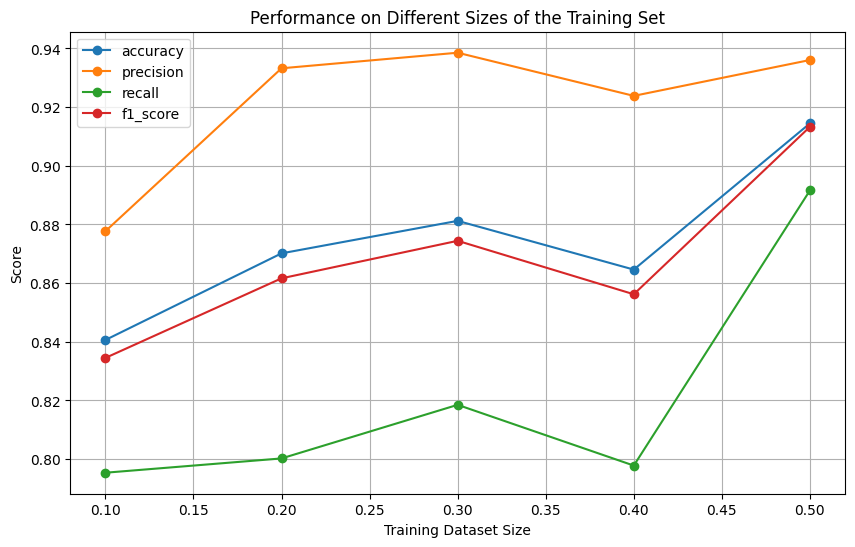

In [67]:
plot_metrics_by_dataset_size(sizes, size_scores, title='Performance on Different Sizes of the Training Set')

#### Regression

Training Noise

In [68]:
# add ndifferent level of noise to the dataset and see how the model performs
# add noise to the dataset
noises = [0.01, 0.05, 0.1, 0.2, 0.5]
training_scores_reg = {'accuracy': [], 'mse': [], 'mae': [], 'rmse': [], 'mape': [], 'r2': []}

for noise in noises:
    print("|Noise: ", noise, "|")
    
    # add some noise to the dataset
    wine_X_train_noisy = wine_X_train.copy() + np.random.normal(0, noise, wine_X_train.shape)
    wine_y_train_noisy = wine_y_train.copy() + np.random.normal(0, noise, wine_y_train.shape)
    
    # train the model
    mlp_noisy = MLP(**best_param_reg)
    metrics = mlp_noisy.fit(wine_X_train_noisy, wine_y_train_noisy, verbose=False)
    
    # evaluate the model
    wine_output = mlp_noisy.predict(wine_X_test.T)
    wine_output = np.round(wine_output)
    
    training_scores_reg["accuracy"].append(accuracy(wine_y_test, wine_output.T))
    training_scores_reg["mse"].append(mse_loss(wine_y_test, wine_output.T))
    training_scores_reg["mae"].append(mae_loss(wine_y_test, wine_output.T))
    training_scores_reg["rmse"].append(rmse_loss(wine_y_test, wine_output.T))
    training_scores_reg["mape"].append(mape_loss(wine_y_test, wine_output.T))
    training_scores_reg["r2"].append(r2_score(wine_y_test, wine_output.T))

|Noise:  0.01 |
|Noise:  0.05 |
|Noise:  0.1 |
|Noise:  0.2 |
|Noise:  0.5 |


[0.5253846153846153, 0.53, 0.5330769230769231, 0.51, 0.5246153846153846]
[0.7053846153846154, 0.6976923076923077, 0.6207692307692307, 0.6823076923076923, 0.6569230769230769]
[0.5361538461538462, 0.5315384615384615, 0.5146153846153846, 0.55, 0.5338461538461539]
[0.8398717850866377, 0.8352797780937281, 0.7878890980139468, 0.8260191839828493, 0.8105079129305752]
[0.09575427350245497, 0.09695421245233753, 0.09270665445488761, 0.09953266178075904, 0.0949410866893021]
[0.08627815284241769, 0.09624240417456142, 0.195884917495999, 0.11617090683884901, 0.14905293623492333]


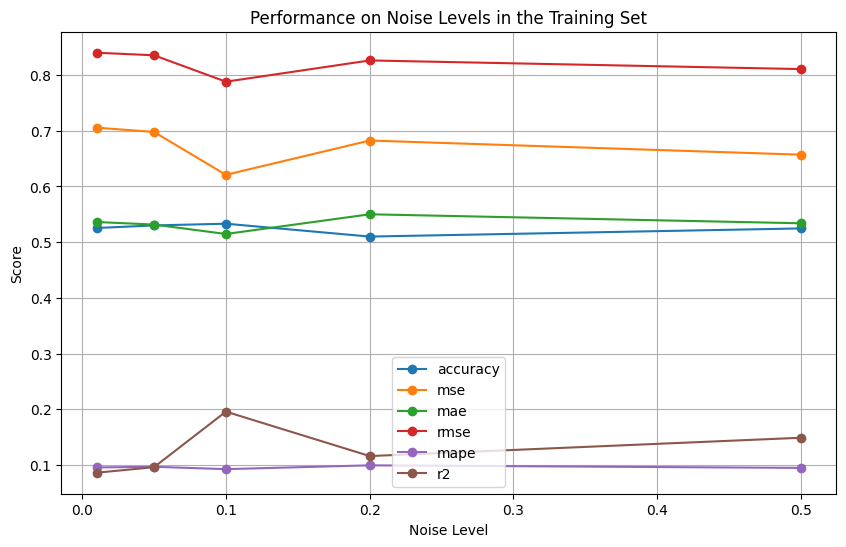

In [69]:
plot_metrics_by_noise(noises, training_scores_reg, title="Performance on Noise Levels in the Training Set")

Testing Noise

In [70]:
# same but for noise in the labels
noises = [0.01, 0.05, 0.1, 0.2, 0.5]
test_scores_reg = {'accuracy': [], 'mse': [], 'mae': [], 'rmse': [], 'mape': [], 'r2': []}

for noise in noises:
    print("|Noise: ", noise, "|")
    
    # add some noise to the dataset
    wine_X_test_noisy = wine_X_test.copy() + np.random.normal(0, noise, wine_X_test.shape)
    wine_y_test_noisy = wine_y_test.copy() + np.random.normal(0, noise, wine_y_test.shape)
    
    wine_y_test_noisy = np.round(wine_y_test_noisy)
    
    # evaluate the model
    wine_output = wine_network.predict(wine_X_test_noisy.T)
    wine_output = np.round(wine_output)
    
    test_scores_reg["accuracy"].append(accuracy(wine_y_test_noisy, wine_output.T))
    test_scores_reg["mse"].append(mse_loss(wine_y_test_noisy, wine_output.T))
    test_scores_reg["mae"].append(mae_loss(wine_y_test_noisy, wine_output.T))
    test_scores_reg["rmse"].append(rmse_loss(wine_y_test_noisy, wine_output.T))
    test_scores_reg["mape"].append(mape_loss(wine_y_test_noisy, wine_output.T))
    test_scores_reg["r2"].append(r2_score(wine_y_test_noisy, wine_output.T))

|Noise:  0.01 |
|Noise:  0.05 |
|Noise:  0.1 |
|Noise:  0.2 |
|Noise:  0.5 |


[0.52, 0.5207692307692308, 0.5184615384615384, 0.5138461538461538, 0.4123076923076923]
[0.7753846153846153, 0.7769230769230769, 0.803076923076923, 0.8184615384615385, 1.2376923076923076]
[0.5476923076923077, 0.5476923076923077, 0.5538461538461539, 0.5615384615384615, 0.7592307692307693]
[0.8805592628464114, 0.8814324006542288, 0.8961455925668123, 0.9046886417224096, 1.112516205586376]
[0.09731043955859843, 0.097202380950544, 0.09843956043769637, 0.09985897435708138, 0.14195604395293457]
[-0.004396534280090458, -0.006389384546519272, -0.040267839075808, -0.05563611386705358, -0.09466150378450289]


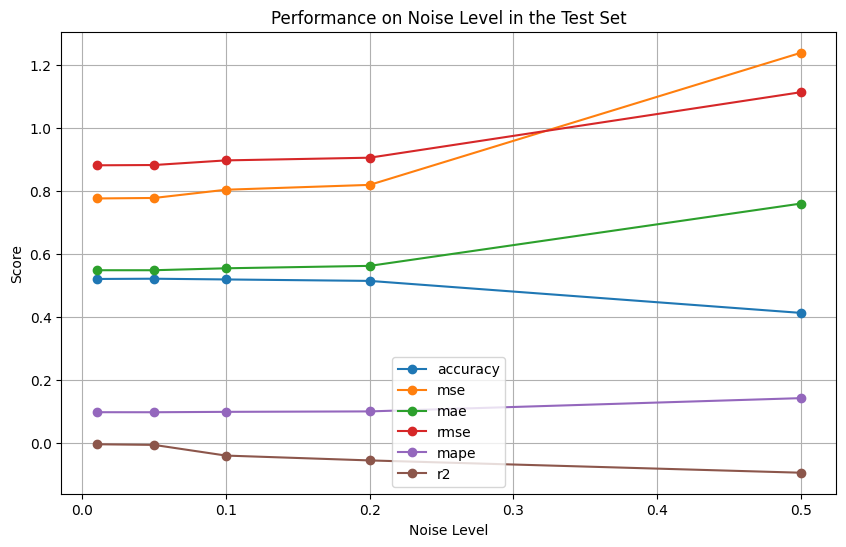

In [71]:
plot_metrics_by_noise(noises, test_scores_reg, title='Performance on Noise Level in the Test Set')

Dataset Size

In [72]:
# variation of the size of the training set and see how the model performs
# set different sizes of the training set
sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
dataset_size_scores_reg = {'accuracy': [], 'mse': [], 'mae': [], 'rmse': [], 'mape': [], 'r2': []}

for size in sizes:
    print("Size: ", size)
    
    # split the training set into a small training set and a validation set
    wine_X_train_small, _, wine_y_train_small, _ = train_test_split(wine_X_train, wine_y_train, test_size=size, random_state=42)
    
    # train the model
    mlp = MLP(**best_param_reg)
    metrics = mlp.fit(wine_X_train_small, wine_y_train_small, verbose=False)
    
    # evaluate the model
    wine_output = mlp.predict(wine_X_test.T)
    wine_output = np.round(wine_output)
    
    dataset_size_scores_reg["accuracy"].append(accuracy(wine_y_test, wine_output.T))
    dataset_size_scores_reg["mse"].append(mse_loss(wine_y_test, wine_output.T))
    dataset_size_scores_reg["mae"].append(mae_loss(wine_y_test, wine_output.T))
    dataset_size_scores_reg["rmse"].append(rmse_loss(wine_y_test, wine_output.T))
    dataset_size_scores_reg["mape"].append(mape_loss(wine_y_test, wine_output.T))
    dataset_size_scores_reg["r2"].append(r2_score(wine_y_test, wine_output.T))

Size:  0.1
Size:  0.2
Size:  0.3
Size:  0.4
Size:  0.5


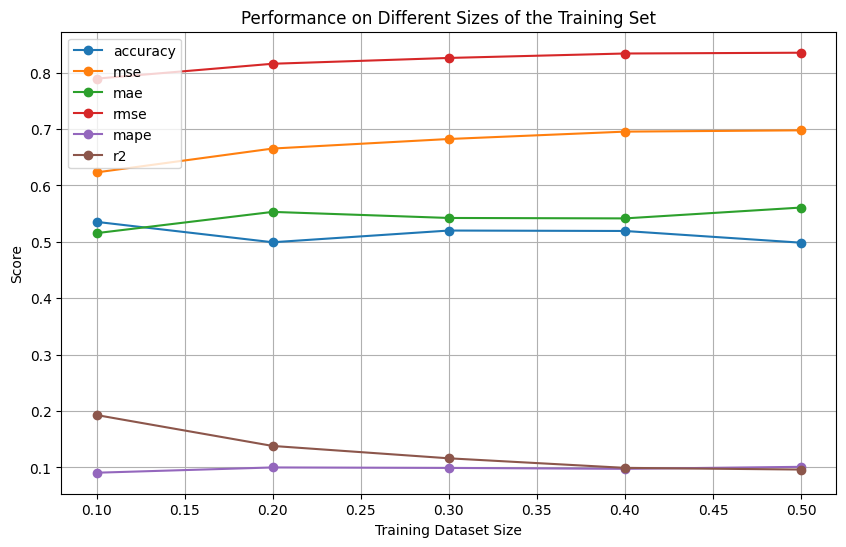

In [73]:
plot_metrics_by_dataset_size(sizes, dataset_size_scores_reg, title='Performance on Different Sizes of the Training Set')

### Complexity

#### Classification

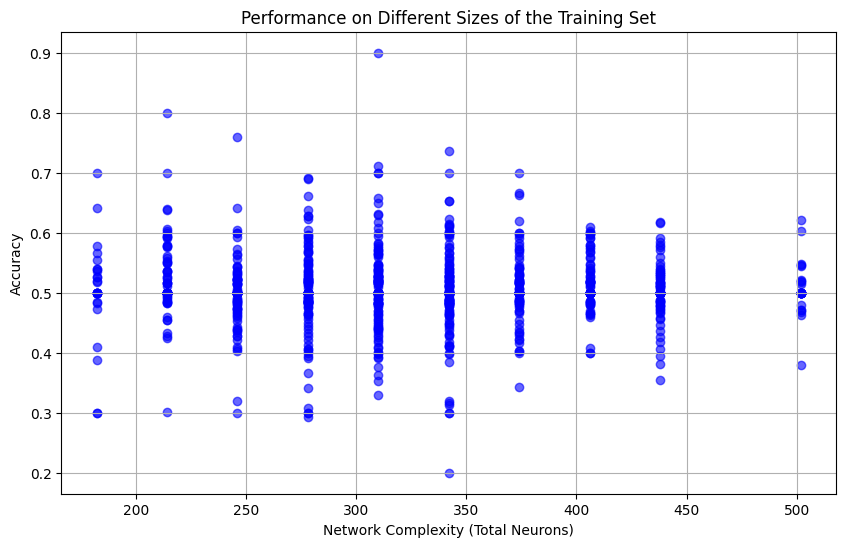

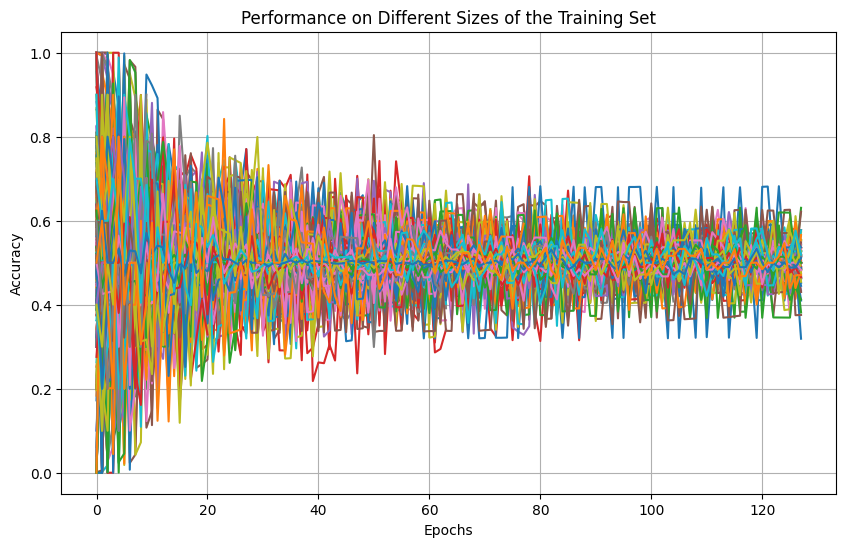

In [81]:
# variation of the complexity of the model and see how the model performs
plot_metrics_by_complexity(results, title='Performance on Different Sizes of the Training Set')
plot_accuracy_during_training(results, title='Performance on Different Sizes of the Training Set')

#### Regression

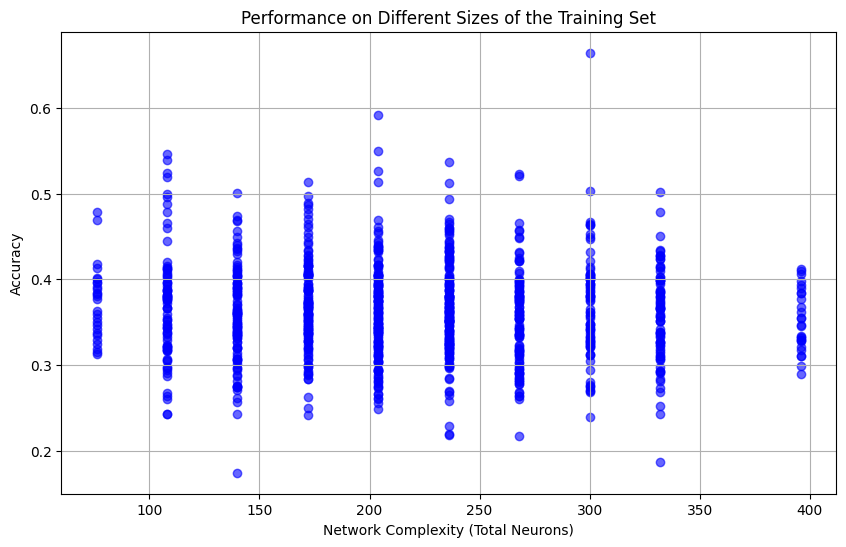

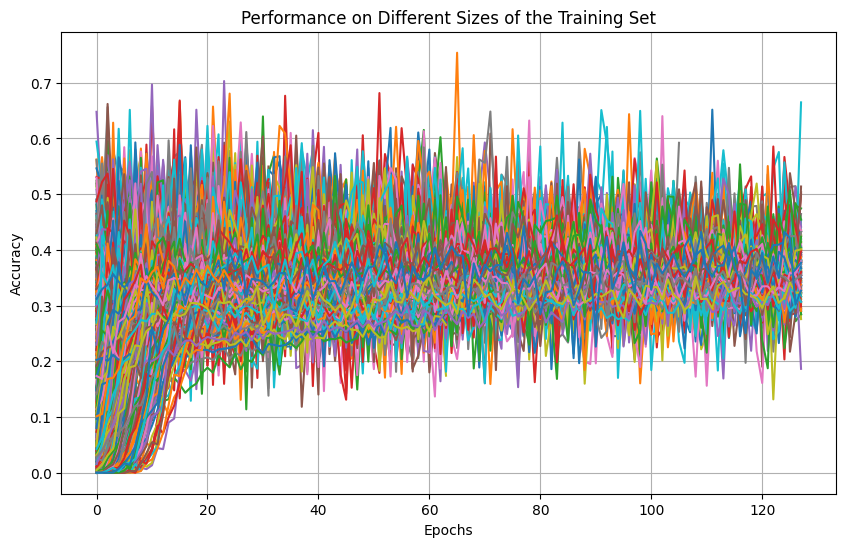

In [83]:
plot_metrics_by_complexity(results_reg, title='Performance on Different Sizes of the Training Set')
plot_accuracy_during_training(results_reg, title='Performance on Different Sizes of the Training Set')

## Comparison with Other Models

### SKLearn MLP Classifier

In [ ]:
sklearn_mlp = MLPClassifier(hidden_layer_sizes=(128, 128, 32), activation='relu', solver='adam', max_iter=1000, random_state=42, batch_size=16, learning_rate_init=0.001)
sklearn_mlp.fit(mushroom_X_train, np.ravel(mushroom_y_train))

MLPClassifier(batch_size=16, hidden_layer_sizes=(128, 128, 32), max_iter=1000,
              random_state=42)

In [ ]:
sklearn_output = sklearn_mlp.predict(mushroom_X_test).reshape(-1, 1)

print("Accuracy: ", accuracy(mushroom_y_test, sklearn_output))
print("Precision: ", precision(mushroom_y_test, sklearn_output))
print("Recall: ", recall(mushroom_y_test, sklearn_output))
print("F1-Score: ", f1_score(mushroom_y_test, sklearn_output))

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-Score:  1.0


### SKLearn MLP Regressor

In [ ]:
sklearn_mlp_reg = MLPRegressor(hidden_layer_sizes=(64, 128), activation='relu', solver='adam', max_iter=1000, random_state=42, batch_size=16, learning_rate_init=0.001)
sklearn_mlp_reg.fit(wine_X_train, np.ravel(wine_y_train))

MLPRegressor(batch_size=16, hidden_layer_sizes=(64, 128), max_iter=1000,
             random_state=42)

In [ ]:
sklearn_output_reg = sklearn_mlp_reg.predict(wine_X_test).reshape(-1, 1)
sklearn_output_reg = np.round(sklearn_output_reg)

print("Accuracy: ", accuracy(wine_y_test, sklearn_output_reg))
print("MSE: ", mse_loss(wine_y_test, sklearn_output_reg))
print("MAE: ", mae_loss(wine_y_test, sklearn_output_reg))
print("RMSE: ", rmse_loss(wine_y_test, sklearn_output_reg))
print("MAPE: ", mape_loss(wine_y_test, sklearn_output_reg))
print("R2: ", r2_score(wine_y_test, sklearn_output_reg))

Accuracy:  0.5453846153846154
MSE:  0.6684615384615384
MAE:  0.5207692307692308
RMSE:  0.817594972135677
MAPE:  0.09439529914350753
R2:  0.13410655923670778
